## COGS 181 Final Project - Few Shot Learning with CIFAR-10 Data

### Overview of Experiment:
- Running Few-Shot Learning on CIFAR-10 Dataset 
- Using two models: AlexNet and ResNet
- Few-Shot Learning Steps:
  1. Subset data into few-shot data sets into k classes with n samples, for each k sample has query set
  2. run model on the subset of the data, record train error and validation error 
  3. after training is done, we run the model on the test set and record test error
  4. repeat for all subsets to get an avg score for train, validatio, test error

#### Imports

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.models as models
from PIL import Image
import random
import pandas as pd

#### Import Data - CIFAR-10

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


tensor([0, 3, 0, 9])


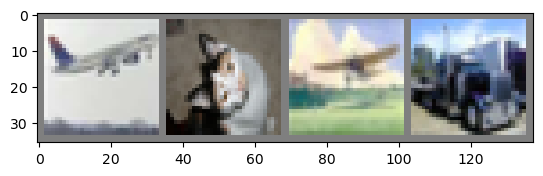

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plane   cat plane truck


In [8]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(labels)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(classes)
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cpu


### Function to create Datasets

In [10]:
def getFewShotData(dataset, classes, num_support_samples, num_query_samples):

    support_set = []
    query_set = []
    for class_name in classes:
        class_indices = np.where(np.array(dataset.targets) == dataset.class_to_idx[class_name])[0]
        selected_indices = np.random.choice(class_indices, num_support_samples + num_query_samples, replace=False)
        for idx, sample_idx in enumerate(selected_indices):
            data, label = dataset.data[sample_idx], dataset.targets[sample_idx]
            if idx < num_support_samples:
                support_set.append((data, label))
            else:
                query_set.append((data, label))
    return support_set, query_set

### ResNet Model

In [11]:
# Function to create ResNet model
def create_resnet_model(num_layers, activation_func, num_classes):
    if num_layers == 18:
        model = models.resnet18(pretrained=True)
    elif num_layers == 34:
        model = models.resnet34(pretrained=True)
    elif num_layers == 50:
        model = models.resnet50(pretrained=True)
    elif num_layers == 101:
        model = models.resnet101(pretrained=True)
    elif num_layers == 152:
        model = models.resnet152(pretrained=True)
    else:
        raise ValueError("Invalid number of layers. Choose from 18, 34, 50, 101, 152.")

    if activation_func == 'ReLU':
        activation = nn.ReLU()
    elif activation_func == 'Sigmoid':
        activation = nn.Sigmoid()
    elif activation_func == 'LeakyReLU':
        activation = nn.LeakyReLU()
    else:
        raise ValueError("Invalid activation function. Choose from ReLU, Sigmoid, LeakyReLU.")

    # Replace the last layer with a new fully connected layer based on the number of classes in the dataset
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

### Pre-process the data

In [12]:
def preprocess_data(support_set, query_set):
    """
    Preprocess data: Convert to Tensors and apply necessary transformations.
    Upscale the images to 224x224 to match ResNet input.
    Assumes data is in NumPy array format.
    """
    upscale_transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
        transforms.Resize((224, 224)),  # Upscale the image to 224x224
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize for ResNet
    ])
    
    # Apply transformations
    support_images = torch.stack([upscale_transform(Image.fromarray(image)) for image, _ in support_set])
    support_labels = torch.tensor([label for _, label in support_set])
    
    query_images = torch.stack([upscale_transform(Image.fromarray(image)) for image, _ in query_set])
    query_labels = torch.tensor([label for _, label in query_set])
    
    return support_images, support_labels, query_images, query_labels

### Defining Training Function --> choosing support, test, query sets and showing accuracy/loss with every epoch

In [13]:
def train_meta_learning(model, tasks, optimizer, num_epochs=10):
    loss_func = nn.CrossEntropyLoss()
    losses = []
    accuracies = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        for task_support, task_query in tasks:
            # Preprocess task data
            support_images, support_labels, query_images, query_labels = preprocess_data(task_support, task_query)
            
            unique_labels = torch.unique(support_labels)
            label_mapping = {int(label.item()): i for i, label in enumerate(unique_labels)}
            # Remap target labels in the support set
            support_labels_mapped = torch.tensor([label_mapping[label.item()] for label in support_labels])
            
            unique_labels = torch.unique(query_labels)
            label_mapping = {int(label.item()): i for i, label in enumerate(unique_labels)}
            # Remap target labels in the support set
            query_labels_mapped = torch.tensor([label_mapping[label.item()] for label in query_labels])
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass: Support set
            output_support = model(support_images)
            loss_support = loss_func(output_support, support_labels_mapped)
            
            # Forward pass: Adaptation on the support set
            num_adaptation_steps = 3  # Can range from 1 to 5 given a small support set
            for _ in range(num_adaptation_steps):
                output_support = model(support_images)
                loss = loss_func(output_support, support_labels_mapped)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    

            # Evaluate on Query Set
            with torch.no_grad():
                output_query = model(query_images)
                loss_query = loss_func(output_query, query_labels_mapped)
                epoch_loss += loss_query.item()
                
                # Calculate accuracy
                _, predicted = torch.max(output_query, 1)
                correct_predictions += (predicted == query_labels_mapped).sum().item()
                total_predictions += len(query_labels_mapped)
                
        # Calculate average loss and accuracy for the epoch
        epoch_loss /= len(tasks)
        accuracy = correct_predictions / total_predictions
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {accuracy}')
        
        losses.append(epoch_loss)
        accuracies.append(accuracy)
    return losses, accuracies

### Defining Testing Function

In [14]:
def test_meta_learning(model, tasks, optimizer):
    loss_func = nn.CrossEntropyLoss()
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for task_support, task_query in tasks:
        # Preprocess task data
        support_images, support_labels, query_images, query_labels = preprocess_data(task_support, task_query)

        unique_labels = torch.unique(support_labels)
        label_mapping = {int(label.item()): i for i, label in enumerate(unique_labels)}
        # Remap target labels in the support set
        support_labels_mapped = torch.tensor([label_mapping[label.item()] for label in support_labels])

        unique_labels = torch.unique(query_labels)
        label_mapping = {int(label.item()): i for i, label in enumerate(unique_labels)}
        # Remap target labels in the query set
        query_labels_mapped = torch.tensor([label_mapping[label.item()] for label in query_labels])

        # Forward pass: Adaptation on the support set
        num_adaptation_steps = 3  # Can range from 1 to 5 given a small support set
        for _ in range(num_adaptation_steps):
            output_support = model(support_images)
            loss = loss_func(output_support, support_labels_mapped)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()  # Accumulate loss

        # Predictions on the query set after adaptation
        output_query = model(query_images)
        _, predicted = torch.max(output_query, 1)
        total_correct += (predicted == query_labels_mapped).sum().item()
        total_samples += len(query_labels_mapped)

    # Calculate average loss and accuracy
    average_loss = total_loss / (len(tasks) * num_adaptation_steps)
    accuracy = total_correct / total_samples
    return average_loss, accuracy


### Generate different few-shot datasets 

In [ ]:
  num_runs = 3
    num_classes = 2
    classes_of_interest = ['cat', 'dog', 'bird', 'frog', 'deer', 'horse']
    num_support_samples = 5
    num_query_samples = 3
    num_epochs = 15
    
    train_data = []
    test_data = []
    
    #Generate the different few shot datasets, task1 and task2 train and a test set for each run/experiment
    for run in range(num_runs):

        random.shuffle(classes_of_interest)
        subset_size = len(classes_of_interest) // 3

        train_classes_task1 = classes_of_interest[:subset_size]
        train_classes_task2 = classes_of_interest[subset_size:2*subset_size]
        test_classes = classes_of_interest[2*subset_size:]

        train_task1_support, train_task1_query = getFewShotData(trainset, train_classes_task1, 
                                                                            num_support_samples, num_query_samples)
        train_task2_support, train_task2_query = getFewShotData(trainset, train_classes_task2, 
                                                                            num_support_samples, num_query_samples)
        test_support, test_query = getFewShotData(trainset, test_classes,
                                                              num_support_samples, num_query_samples)
        train_tasks = [(train_task1_support, train_task1_query), (train_task2_support, train_task2_query)]
        test_task = [(test_support, test_query)]
        
        train_data.append(train_tasks)
        test_data.append(test_task)

### Running and Training Model on Different Experiments/Combinations - ResNet

In [1]:
def run_experiments(num_runs):

    
    num_layers_list = [18, 50, 152] #still need to do 34, 101
    optimizer_list = ["Adam", "SGD"]
    activation_func_list = ['ReLU', 'Sigmoid', 'LeakyReLU']
    
    
    avg_train_losses = []
    avg_train_accuracies = []
    avg_test_accuracy = []
    avg_test_loss = []
    

        
    
    #for each combination of hyperparamaters, train the model on the different sets of data nd average metrics
    for num_layers in num_layers_list:
        print(num_layers)
        for optimizer_name in optimizer_list:
            print(optimizer_name)
            for activation_func in activation_func_list:
                print(activation_func)
                test_accuracies = 0
                test_losses = 0
                train_losses = []
                train_accuracies = []
    
                for i in range(num_runs):
                    print(i)
                    RNmodel = create_resnet_model(num_layers, activation_func, num_classes)
                    loss_func = nn.CrossEntropyLoss()

                    if optimizer_name == "SGD":
                        optimizer = optim.SGD(RNmodel.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
                    elif optimizer_name == "Adam":
                        optimizer = optim.Adam(RNmodel.parameters(), lr=0.001, weight_decay=1e-4)

                    losses, accuracies = train_meta_learning(RNmodel, train_data[i], optimizer, num_epochs)
                  
                    train_losses.append(losses)
                    train_accuracies.append(accuracies)
                    
                    test_loss, test_accuracy = test_meta_learning(RNmodel, test_data[i], optimizer)
                    
                    test_losses += test_loss
                    test_accuracies += test_accuracy
                    
                
                train_losses = np.mean(train_losses, axis = 0)
                train_accuracies = np.mean(train_accuracies, axis = 0)
                
                test_losses = test_losses/num_runs
                test_accuracies = test_accuracies/num_runs
                
                print(test_accuracies)
                
                avg_train_losses.append(train_losses)
                avg_train_accuracies.append(train_accuracies)
                avg_test_loss.append(test_losses)
                avg_test_accuracy.append(test_accuracies)
                
                
                
    return avg_train_losses, avg_train_accuracies, avg_test_loss, avg_test_accuracy


num_runs = 3
avg_train_losses, avg_train_accuracies, avg_test_loss, avg_test_accuracy = run_experiments(num_runs)

### Plotting Avg Train Loss, Avg Train Accuracy over the Epochs - ResNet

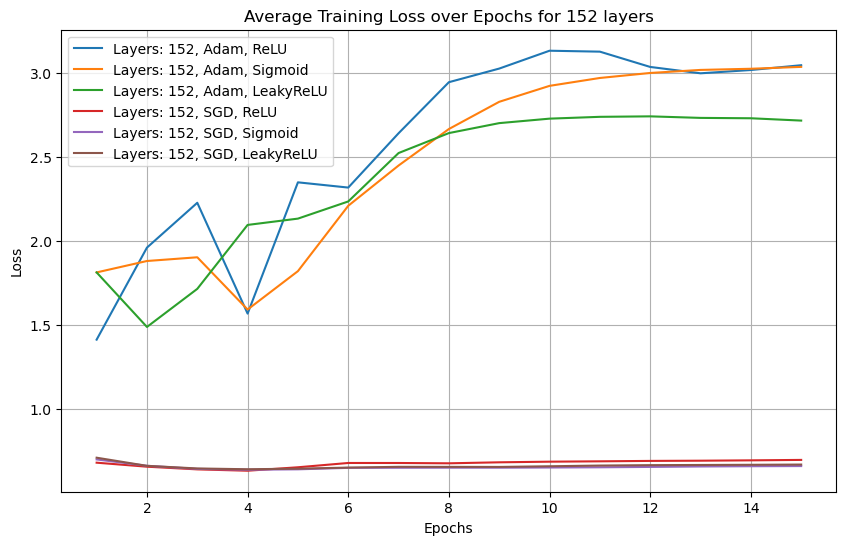

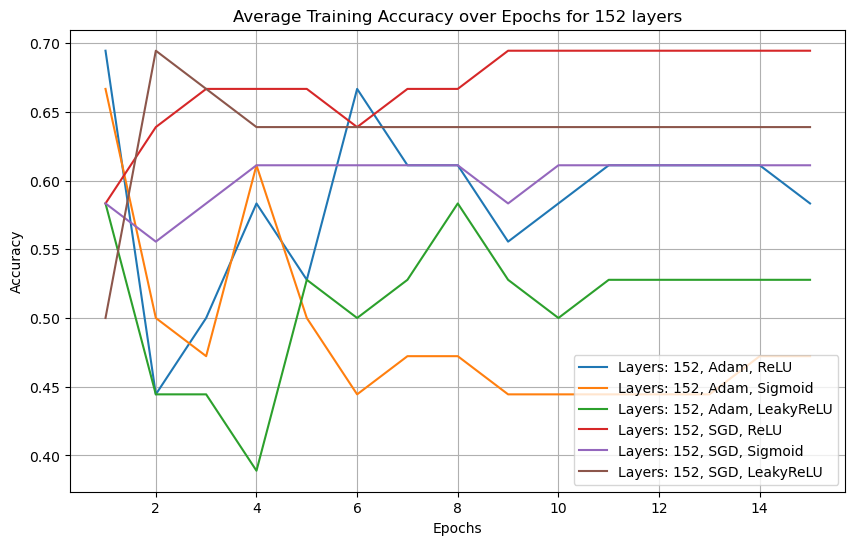

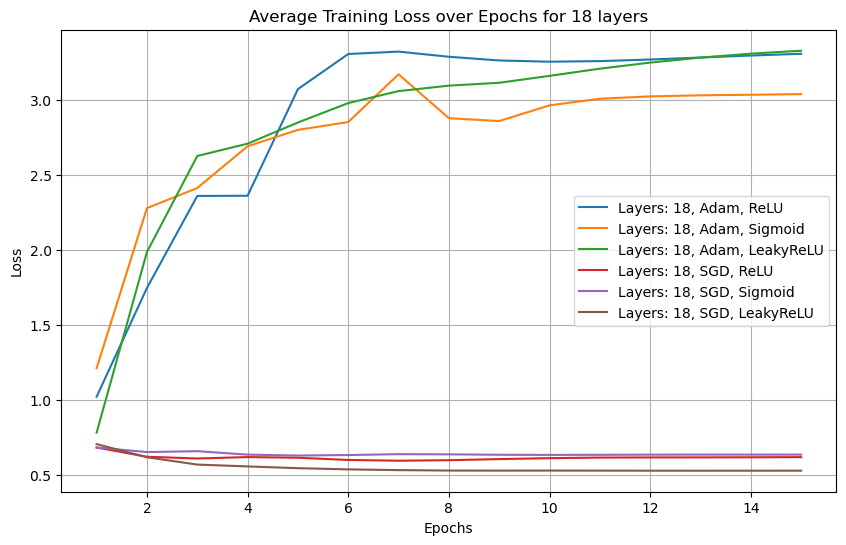

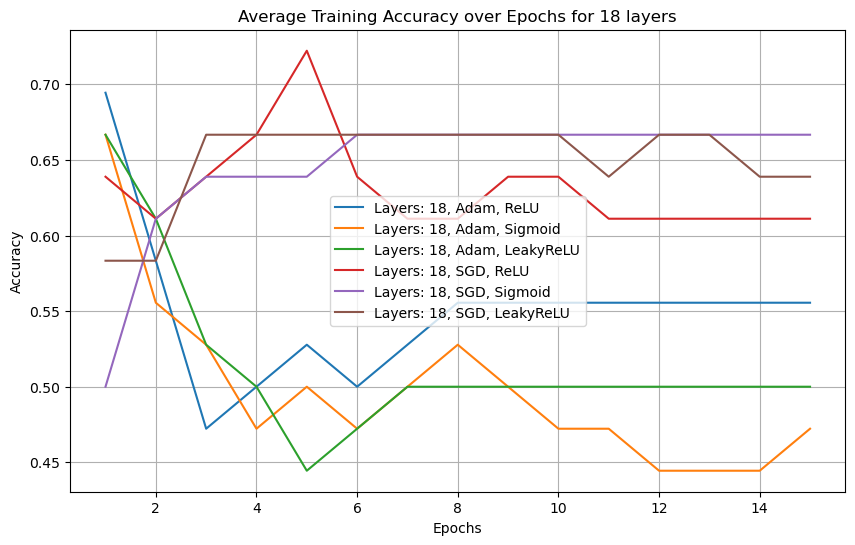

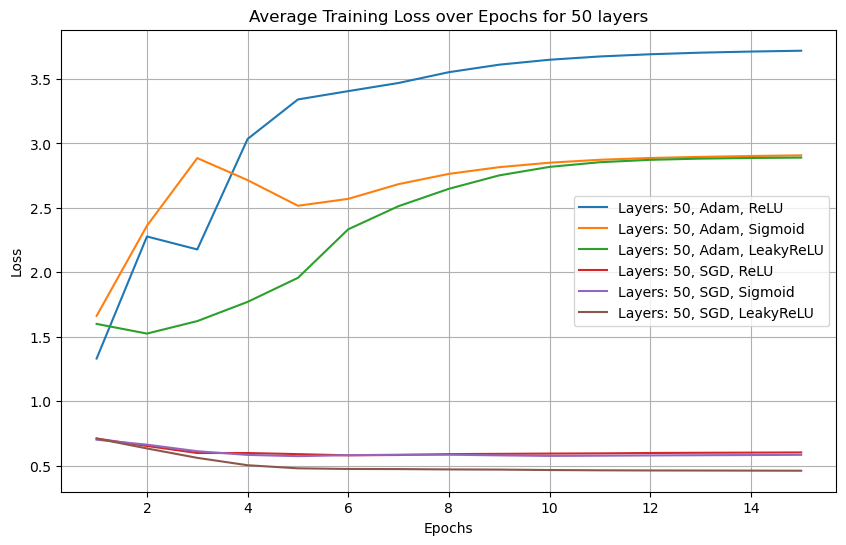

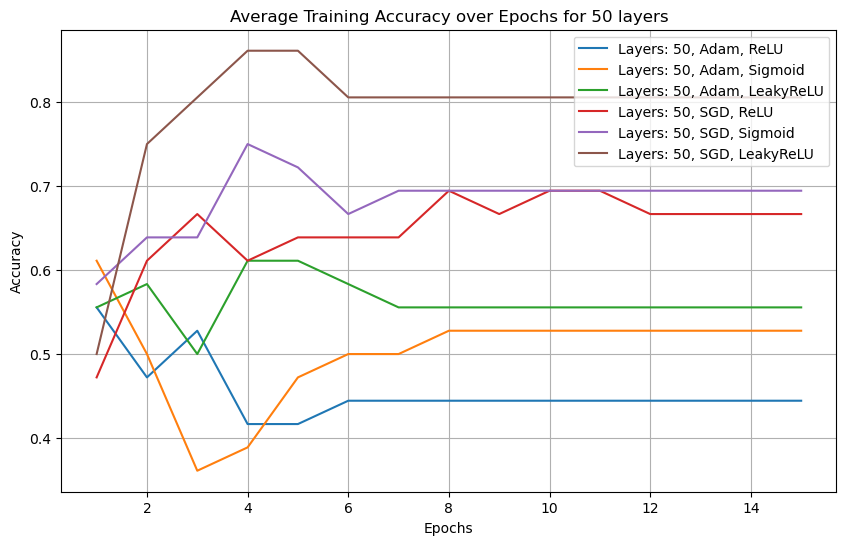

In [51]:
labels = ['Layers: 18, Adam, ReLU', 'Layers: 18, Adam, Sigmoid', 'Layers: 18, Adam, LeakyReLU',
                'Layers: 18, SGD, ReLU', 'Layers: 18, SGD, Sigmoid', 'Layers: 18, SGD, LeakyReLU',
                'Layers: 50, Adam, ReLU', 'Layers: 50, Adam, Sigmoid', 'Layers: 50, Adam, LeakyReLU',
                'Layers: 50, SGD, ReLU', 'Layers: 50, SGD, Sigmoid', 'Layers: 50, SGD, LeakyReLU',
                'Layers: 152, Adam, ReLU', 'Layers: 152, Adam, Sigmoid', 'Layers: 152, Adam, LeakyReLU', 
                'Layers: 152, SGD, ReLU', 'Layers: 152, SGD, Sigmoid', 'Layers: 152, SGD, LeakyReLU']


def plot_train_metrics(avg_train_losses, avg_train_accuracies, num_epochs, labels):
    unique_layers = set([label.split(',')[0].split(': ')[1] for label in labels])
    for layer in unique_layers:
        layer_train_losses = [avg_train_losses[i] for i, label in enumerate(labels) if label.startswith(f'Layers: {layer}')]
        layer_train_accuracies = [avg_train_accuracies[i] for i, label in enumerate(labels) if label.startswith(f'Layers: {layer}')]

        plt.figure(figsize=(10, 6))
        epochs = np.arange(1, num_epochs + 1)
        layer_labels = [label for label in labels if label.startswith(f'Layers: {layer}')]
        
        
        # Plot average training losses for this layer
        for train_losses in layer_train_losses:
            plt.plot(epochs, train_losses)
        plt.title(f'Average Training Loss over Epochs for {layer} layers')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(layer_labels)
        plt.grid(True)
        plt.show()
        
        # Plot average training accuracies for this layer
        plt.figure(figsize=(10, 6))
        for train_accuracies in layer_train_accuracies:
            plt.plot(epochs, train_accuracies)
        plt.title(f'Average Training Accuracy over Epochs for {layer} layers')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(layer_labels)
        plt.grid(True)
        plt.show()


# Assuming num_epochs is defined
num_epochs = len(avg_train_losses[0])  # Assuming all runs have the same number of epochs
plot_train_metrics(avg_train_losses, avg_train_accuracies, num_epochs, labels)

### Creating Same Plots for Avg Test Loss and Avg Test Accuracy - ResNet

152


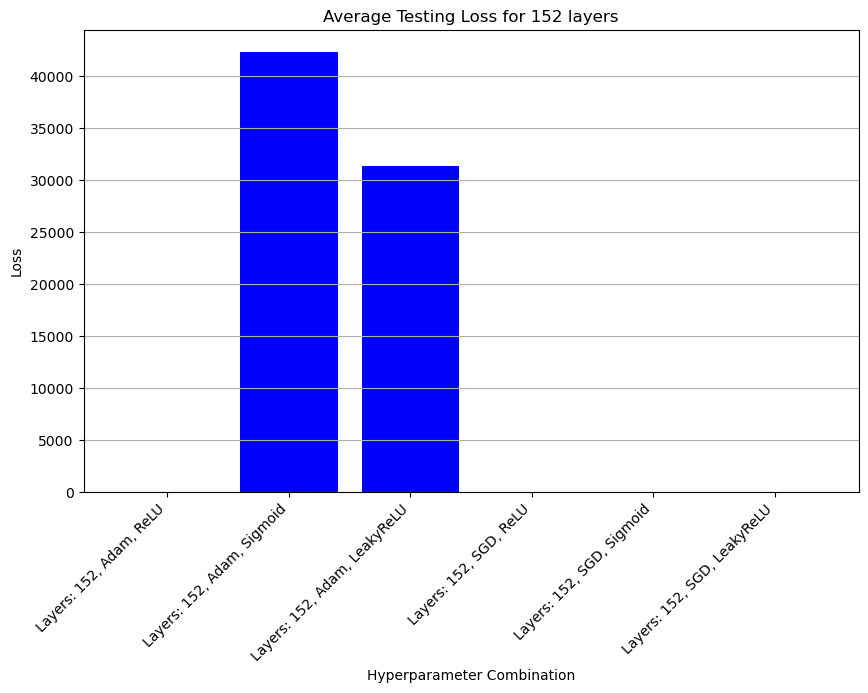

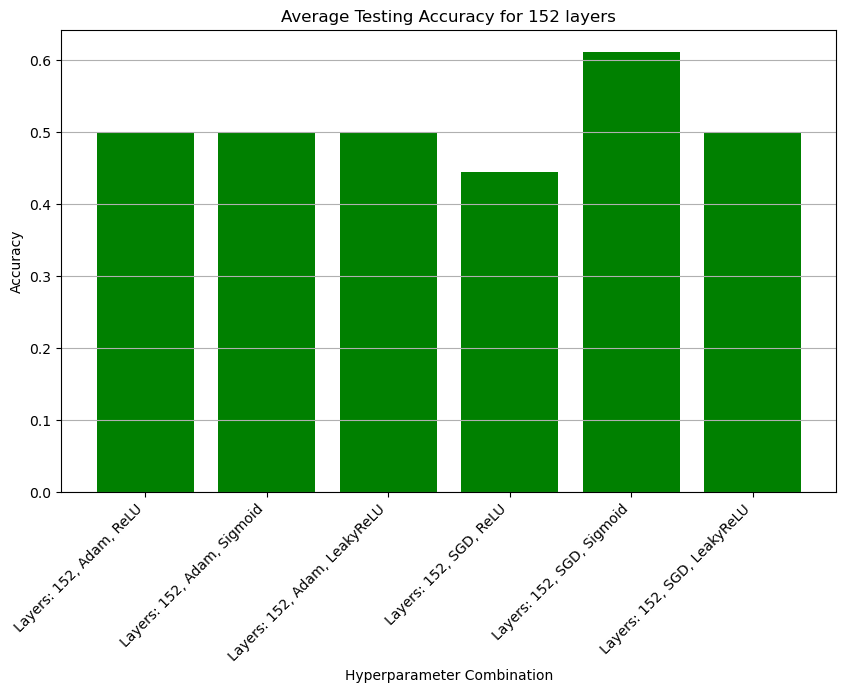

18


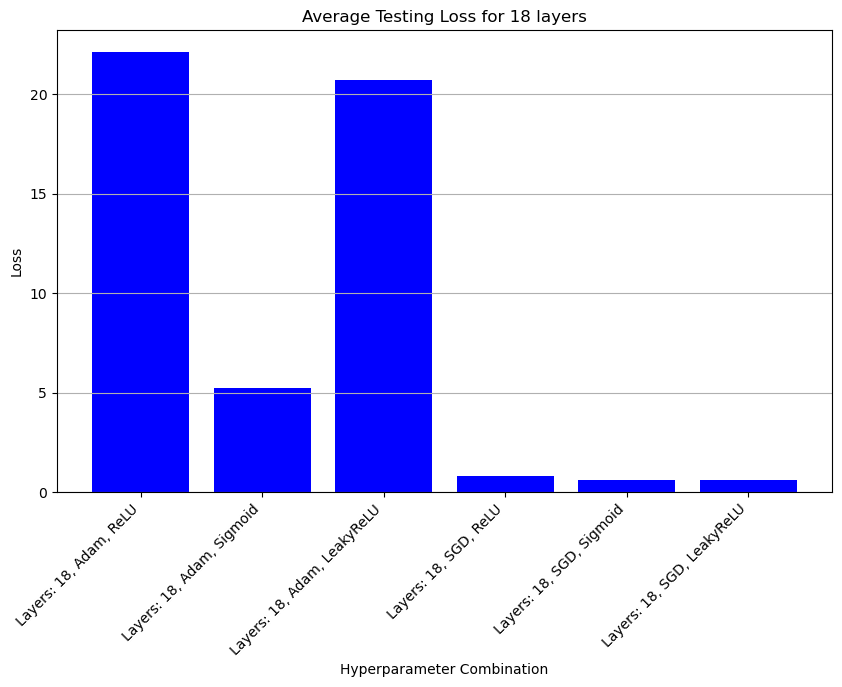

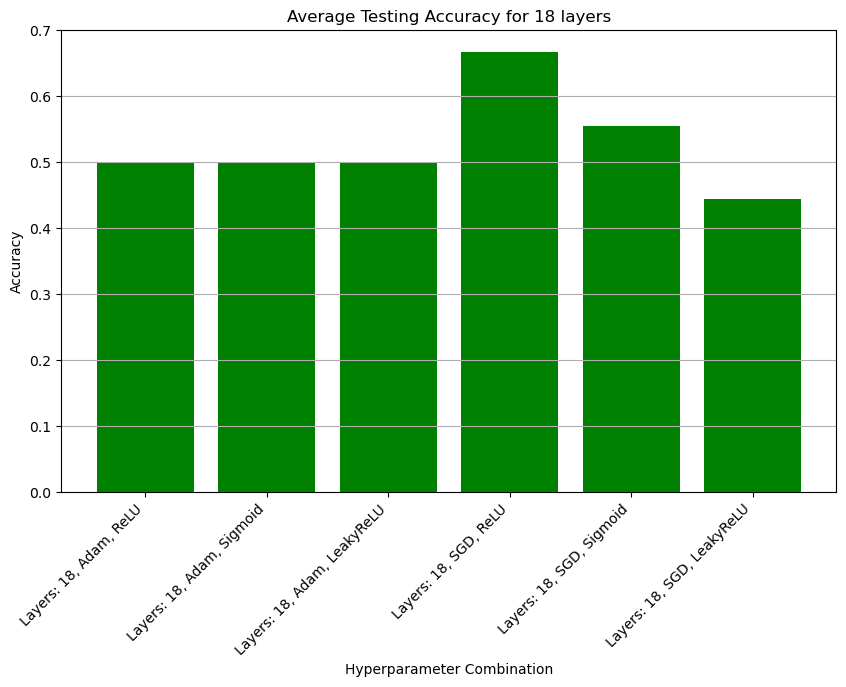

50


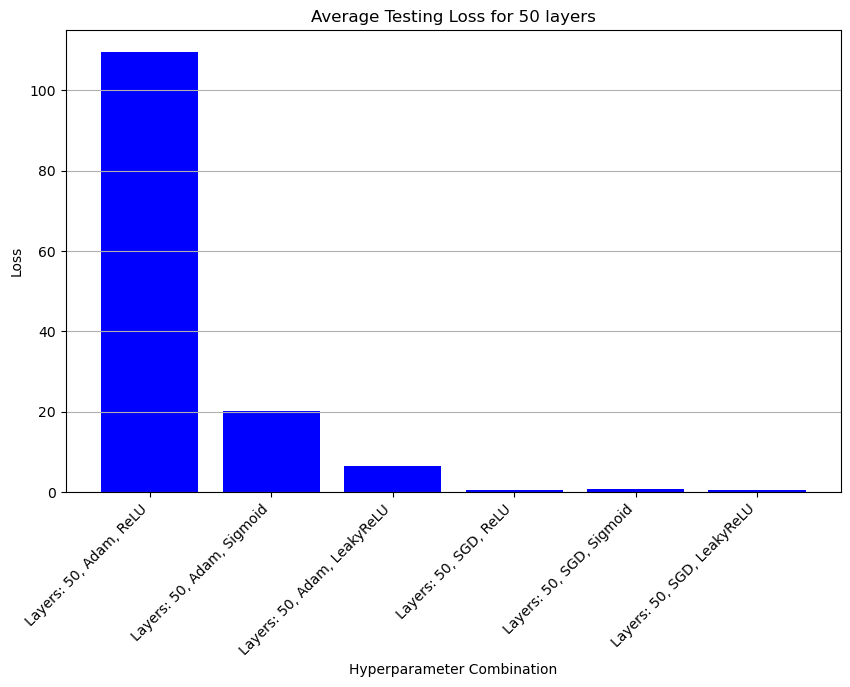

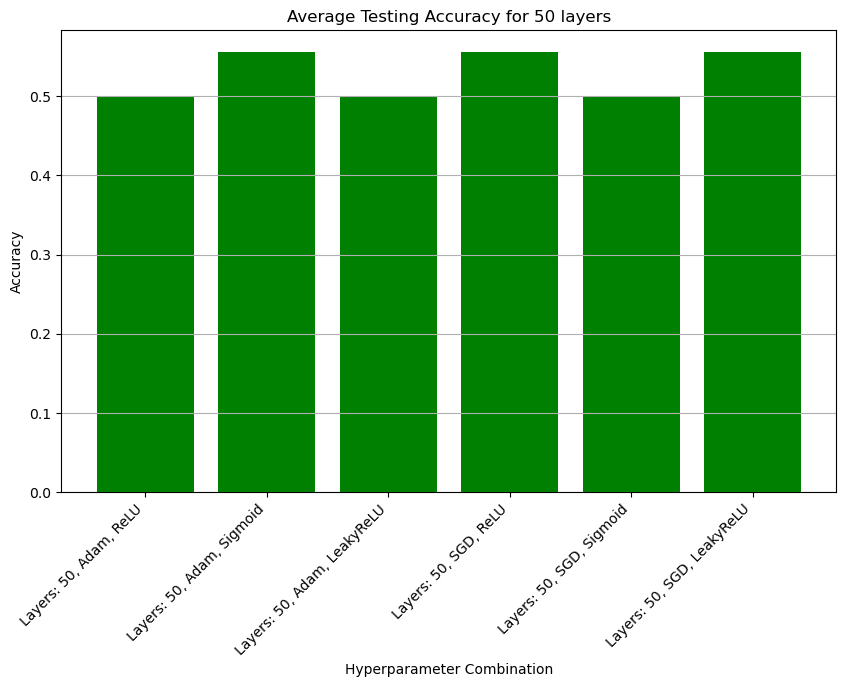

In [49]:
labels = ['Layers: 18, Adam, ReLU', 'Layers: 18, Adam, Sigmoid', 'Layers: 18, Adam, LeakyReLU',
                'Layers: 18, SGD, ReLU', 'Layers: 18, SGD, Sigmoid', 'Layers: 18, SGD, LeakyReLU',
                'Layers: 50, Adam, ReLU', 'Layers: 50, Adam, Sigmoid', 'Layers: 50, Adam, LeakyReLU',
                'Layers: 50, SGD, ReLU', 'Layers: 50, SGD, Sigmoid', 'Layers: 50, SGD, LeakyReLU',
                'Layers: 152, Adam, ReLU', 'Layers: 152, Adam, Sigmoid', 'Layers: 152, Adam, LeakyReLU', 
                'Layers: 152, SGD, ReLU', 'Layers: 152, SGD, Sigmoid', 'Layers: 152, SGD, LeakyReLU']

def plot_test_metrics(avg_test_loss, avg_test_accuracy, labels):
    num_combinations = len(avg_test_loss)
    
    unique_layers = set([label.split(',')[0].split(': ')[1] for label in labels])
    for layer in unique_layers:
        layer_test_loss = [avg_test_loss[i] for i, label in enumerate(labels) if label.startswith(f'Layers: {layer}')]
        layer_test_accuracy = [avg_test_accuracy[i] for i, label in enumerate(labels) if label.startswith(f'Layers: {layer}')]

        num_combinations = len(layer_test_loss)
        layer_labels = [label for label in labels if label.startswith(f'Layers: {layer}')]

        # Plot average testing loss for this layer
        plt.figure(figsize=(10, 6))
        plt.bar(np.arange(num_combinations), layer_test_loss, color='blue')
        plt.title(f'Average Testing Loss for {layer} layers')
        plt.xlabel('Hyperparameter Combination')
        plt.ylabel('Loss')
        plt.xticks(np.arange(num_combinations), layer_labels, rotation=45, ha='right')
        plt.grid(axis='y')
        plt.show()

        # Plot average testing accuracy for this layer
        plt.figure(figsize=(10, 6))
        plt.bar(np.arange(num_combinations), layer_test_accuracy, color='green')
        plt.title(f'Average Testing Accuracy for {layer} layers')
        plt.xlabel('Hyperparameter Combination')
        plt.ylabel('Accuracy')
        plt.xticks(np.arange(num_combinations), layer_labels, rotation=45, ha='right')
        plt.grid(axis='y')
        plt.show()
        
        
# Assuming avg_test_loss and avg_test_accuracy are lists containing average values for each combination of hyperparameters
plot_test_metrics(avg_test_loss, avg_test_accuracy, labels)

### Creating AlexNet Model

In [18]:
def create_alex_net():
    #create the network 
    alex_net = models.alexnet(pretrained = True)
    num_features = alex_net.classifier[6].in_features
    
    #change the last fully connected layer to 2 classes to match our training/test set of 2 classes
    alex_net.classifier[6] = nn.Linear(num_features, 2)
    
    #changing activation_func
#     if activation_func == "Sigmoid":
#         alex_net.features[1] = nn.Sigmoid()  
#         alex_net.features[4] = nn.Sigmoid()
#         alex_net.features[7] = nn.Sigmoid()  
#         alex_net.features[9] = nn.Sigmoid()  
#         alex_net.features[11] = nn.Sigmoid() 
#         alex_net.classifier[2] = nn.Sigmoid()  
#         alex_net.classifier[4] = nn.Sigmoid()
        
#     elif activation_func == "ReLU":
#         alex_net.features[1] = nn.ReLU()  
#         alex_net.features[4] = nn.ReLU() 
#         alex_net.features[7] = nn.ReLU()  
#         alex_net.features[9] = nn.ReLU()   
#         alex_net.features[11] = nn.ReLU()  
#         alex_net.classifier[2] = nn.ReLU() 
#         alex_net.classifier[4] = nn.ReLU() 
    
#     elif activation_func == "LeakyReLU": 
#         alex_net.features[1] = nn.LeakyReLU()  
#         alex_net.features[4] = nn.LeakyReLU() 
#         alex_net.features[7] = nn.LeakyReLU() 
#         alex_net.features[9] = nn.LeakyReLU() 
#         alex_net.features[11] = nn.LeakyReLU()  
#         alex_net.classifier[2] = nn.LeakyReLU()
#         alex_net.classifier[4] = nn.LeakyReLU()
        
#     else:
#         raise ValueError("Invalid activation function. Choose from ReLU, Sigmoid, LeakyReLU.")
        
    return alex_net

### Initiating AlexNet

In [19]:
alex_net = create_alex_net()

loss_function = nn.CrossEntropyLoss()

optimizer_name = "Adam"  # Or "SGD"
if optimizer_name == "SGD":
    optimizer_an = optim.SGD(alex_net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
elif optimizer_name == "Adam":
    optimizer_an = optim.Adam(alex_net.parameters(), lr=0.001, weight_decay=1e-4)

/Users/gayathridonepudi/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gayathridonepudi/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training Set for AlexNet

### Running Experiments of Different Combination Models for AlexNet

In [22]:
def run_experiments_alex(num_runs):

    optimizer_list = ["Adam", "SGD"]
    
    
    avg_train_losses = []
    avg_train_accuracies = []
    avg_test_accuracy = []
    avg_test_loss = []
    
    
    #for each combination of hyperparamaters, train the model on the different sets of data and average metrics
    for optimizer_name in optimizer_list:
        print(optimizer_name)
        test_accuracies = 0
        test_losses = 0
        train_losses = []
        train_accuracies = []
    
        for i in range(num_runs):
            print(i)
            alexnet = create_alex_net()
            loss_func = nn.CrossEntropyLoss()

            if optimizer_name == "SGD":
                optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
            elif optimizer_name == "Adam":
                optimizer = optim.Adam(alexnet.parameters(), lr=0.001, weight_decay=1e-4)

            losses, accuracies = train_meta_learning(alexnet, train_data[i], optimizer, num_epochs)
                  
            train_losses.append(losses)
            train_accuracies.append(accuracies)
                    
            test_loss, test_accuracy = test_meta_learning(alexnet, test_data[i], optimizer)
                    
            test_losses += test_loss
            test_accuracies += test_accuracy
                    
                
            train_losses1 = np.mean(train_losses, axis = 0)
            train_accuracies1 = np.mean(train_accuracies, axis = 0)
                
            test_losses1 = test_losses/num_runs
            test_accuracies1 = test_accuracies/num_runs
                
            print(test_accuracies)
                
        avg_train_losses.append(train_losses1)
        avg_train_accuracies.append(train_accuracies1)
        avg_test_loss.append(test_losses1)
        avg_test_accuracy.append(test_accuracies1)
                
                
                
    return avg_train_losses, avg_train_accuracies, avg_test_loss, avg_test_accuracy

### Testing using Function Above

In [23]:
num_runs = 3
avg_train_losses, avg_train_accuracies, avg_test_loss, avg_test_accuracy = run_experiments_alex(num_runs)

Adam
0
Epoch 1/15, Loss: 0.7508486211299896, Accuracy: 0.4166666666666667
Epoch 2/15, Loss: 0.7085871696472168, Accuracy: 0.5
Epoch 3/15, Loss: 1.8968013525009155, Accuracy: 0.4166666666666667
Epoch 4/15, Loss: 1.1120941191911697, Accuracy: 0.4166666666666667
Epoch 5/15, Loss: 1.4539454281330109, Accuracy: 0.6666666666666666
Epoch 6/15, Loss: 1.7810662388801575, Accuracy: 0.5
Epoch 7/15, Loss: 6.663997769355774, Accuracy: 0.5833333333333334
Epoch 8/15, Loss: 1.5902243256568909, Accuracy: 0.5
Epoch 9/15, Loss: 2.356054663658142, Accuracy: 0.5833333333333334
Epoch 10/15, Loss: 2.7670734524726868, Accuracy: 0.5833333333333334
Epoch 11/15, Loss: 2.7559441924095154, Accuracy: 0.6666666666666666
Epoch 12/15, Loss: 0.9918883293867111, Accuracy: 0.5
Epoch 13/15, Loss: 6.000367045402527, Accuracy: 0.5
Epoch 14/15, Loss: 3.8571752309799194, Accuracy: 0.5
Epoch 15/15, Loss: 2.5828041434288025, Accuracy: 0.6666666666666666
0.5
1
Epoch 1/15, Loss: 0.7122768759727478, Accuracy: 0.5
Epoch 2/15, Loss:

In [24]:
avg_train_losses

[array([0.83058341, 0.8570482 , 1.66168045, 1.11535674, 1.41356741,
        3.03728323, 7.64203863, 3.53085561, 5.427085  , 3.96238447,
        5.14956602, 0.87361077, 2.75404145, 3.81137902, 1.78220187]),
 array([0.62081889, 0.81497231, 0.95034708, 1.07535973, 1.35642672,
        1.27968315, 1.24837701, 1.49487423, 1.45441644, 1.52400608,
        1.42960368, 1.51050816, 1.34092841, 1.47889894, 1.56926531])]

### Creating Plots for AlexNet - Avg Train Loss and Accuracy

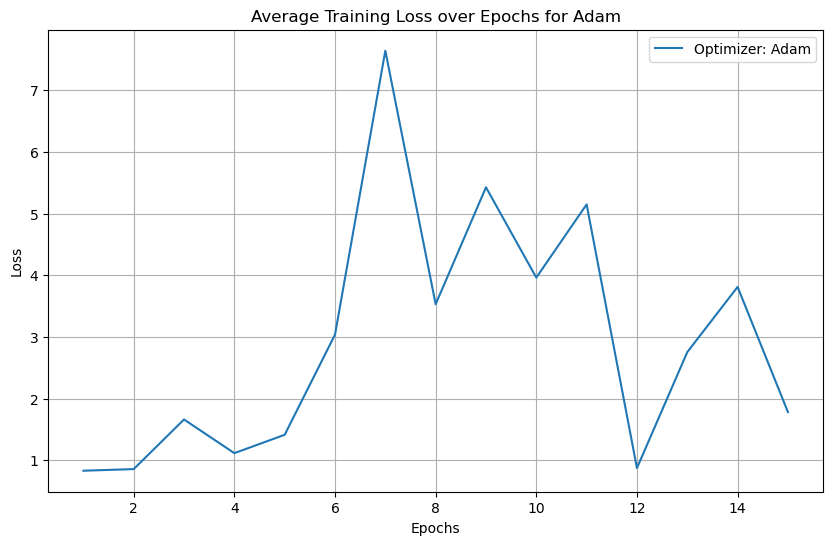

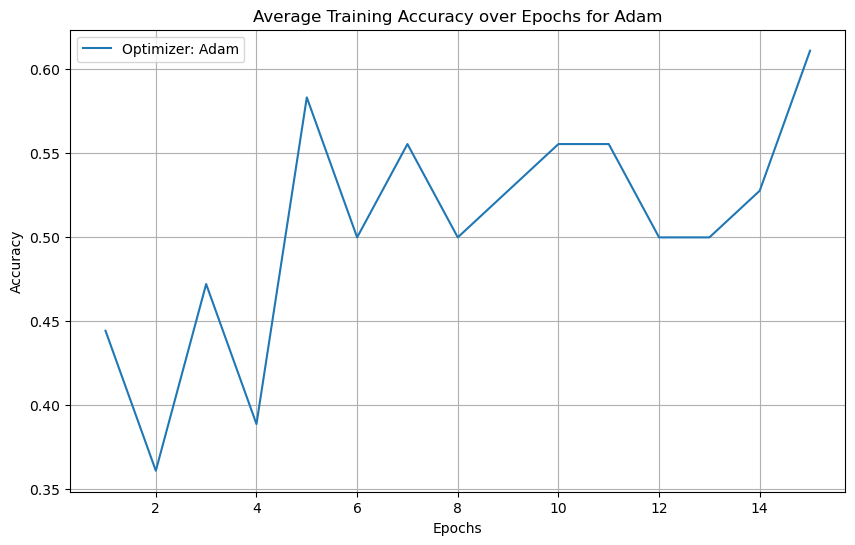

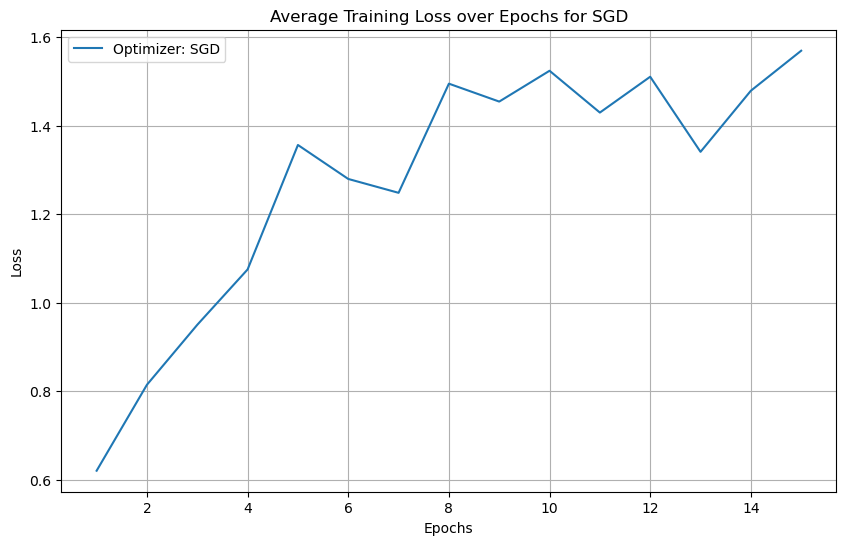

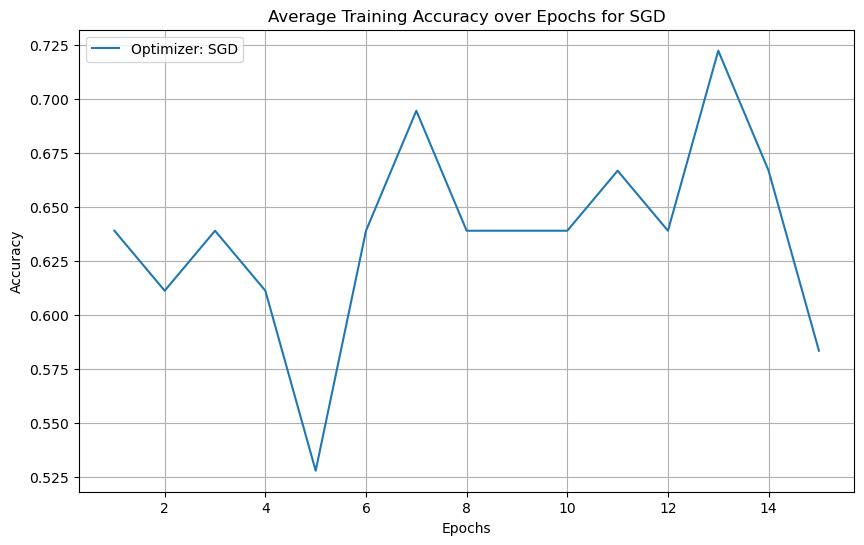

In [28]:
labels1 = ['Optimizer: Adam', 'Optimizer: SGD']


def plot_train_metrics(avg_train_losses, avg_train_accuracies, num_epochs, labels):
    unique_layers = set([label.split(',')[0].split(': ')[1] for label in labels])
    for layer in unique_layers:
        layer_train_losses = [avg_train_losses[i] for i, label in enumerate(labels) if label.startswith(f'Optimizer: {layer}')]
        layer_train_accuracies = [avg_train_accuracies[i] for i, label in enumerate(labels) if label.startswith(f'Optimizer: {layer}')]

        plt.figure(figsize=(10, 6))
        epochs = np.arange(1, num_epochs + 1)
        layer_labels = [label for label in labels if label.startswith(f'Optimizer: {layer}')]
        
        
        # Plot average training losses for this layer
        for train_losses in layer_train_losses:
            plt.plot(epochs, train_losses)
        plt.title(f'Average Training Loss over Epochs for {layer}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(layer_labels)
        plt.grid(True)
        plt.show()
        
        # Plot average training accuracies for this layer
        plt.figure(figsize=(10, 6))
        for train_accuracies in layer_train_accuracies:
            plt.plot(epochs, train_accuracies)
        plt.title(f'Average Training Accuracy over Epochs for {layer}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(layer_labels)
        plt.grid(True)
        plt.show()



# Assuming num_epochs is defined
num_epochs = len(avg_train_losses[0])  # Assuming all runs have the same number of epochs
plot_train_metrics(avg_train_losses, avg_train_accuracies, num_epochs, labels1)